# Dive Prediction - Matrix Distance Simple Network

*Predicting Seabird Diving Behaviour from GPS data*

This notebook trains a neural network to predict seabirds' dives.

Networks' characteristics:

* *Trajectory window* : 100s
* *Output resolution*: 10s
* *Representation of trajectories* : Matrix Distance
* *Layers* : 1x1 convolutions

## connect to drive

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
%cd drive/My\ Drive/

/content/drive/My Drive


## load data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from utils.trip import * 

In [4]:
data_train = pd.read_csv('./data/data_train.csv')
data_validation = pd.read_csv('./data/data_validation.csv')
data_test = pd.read_csv('./data/data_test.csv')

## choose window

In [5]:
# Hyperparameters
window = 100
rescale = 10
variable = ('lon', 'lat')

train_set = TrajDataSet(data_train, window, variable)
d = DistMatrix()
r = Rescale(rescale)

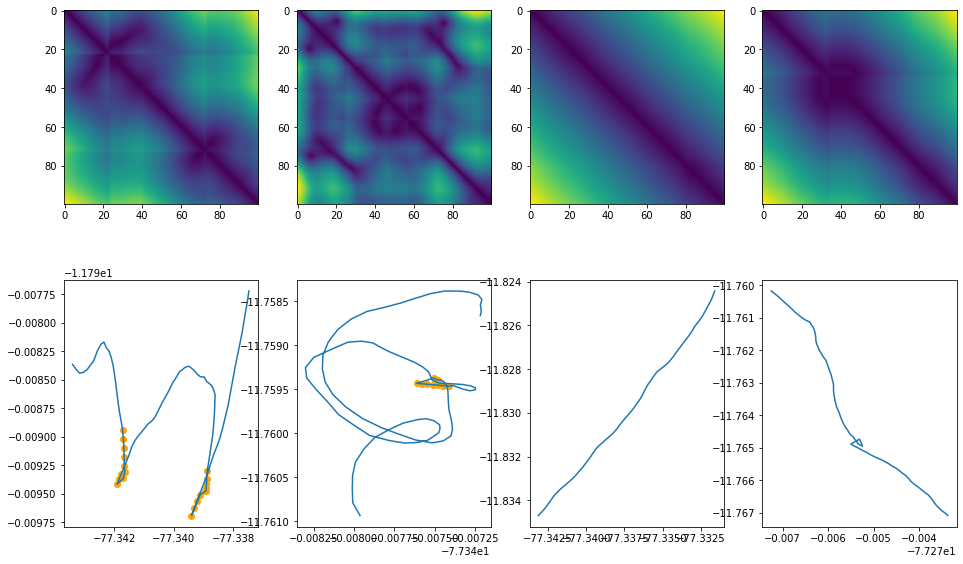

In [7]:
plt.figure(figsize=(16, 10))
idx = np.random.randint(0, len(train_set), 4)

k = -1
for i in idx:
    k += 1
    traj, dive = train_set[i]
    matrix_dist, dive = r(d(train_set[i]))
    

    plt.subplot(2,4, k+1)
    plt.imshow(matrix_dist)

    plt.subplot(2,4, k+5)
    dive = [dive[i] for i in range(len(dive)) for k in range(rescale) ]
    plt.plot(traj[0,:], traj[1,:])
    plt.scatter(traj[0, np.array(dive, dtype = 'bool')], traj[1,np.array(dive, dtype = 'bool')], c='orange')

# Neural Network

In [8]:
# hyperparameters
batch_size = 64
learning_rate = 0.01

## reduce size dataset
train_set = TrajDataSet(data_train, window, variable, transform = transforms.Compose([Rescale(rescale), DistMatrix(), ToTensor()]))
validation_set = TrajDataSet(data_validation, window, variable, transform = transforms.Compose([Rescale(rescale), DistMatrix(), ToTensor()]))

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=False)
validation_loader = DataLoader(validation_set, batch_size=batch_size, num_workers = 0, shuffle = True, drop_last=False)

In [9]:
class ConvNet(nn.Module):

    def __init__(self):
        super(ConvNet, self).__init__()

        self.threshold_1 = nn.Sequential(
            nn.BatchNorm2d(1),
            nn.Conv2d(1, 4, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = True),
            nn.ReLU()
        )

        self.threshold_2 = nn.Sequential(
            nn.BatchNorm1d(4),
            nn.AvgPool1d(kernel_size = rescale, stride = rescale),
            nn.ReLU(),
            nn.Conv1d(4, 1, kernel_size = 1, stride = 1, padding = 0, dilation = 1, bias = True)
            
        )
        

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        out = self.threshold_1(x)
        out = torch.sum(out, 2)
        out = self.threshold_2(out)
        return out


def get_score(out, y):
    out = 1*(out>0)
    true_positive = np.mean(out[y == True].numpy()) 
    true_negative = 1-np.mean(out[y == False].numpy())
    
    return (round(true_positive*100) , round(true_negative*100))
#     return (true_positive.detach().numpy().item() , true_negative.detach().numpy().item())

In [10]:
# get sample
x, y = next(iter(train_loader)) 

# Forward model
model = ConvNet()
out = model(x)

# Loss and score
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCEWithLogitsLoss(pos_weight = torch.FloatTensor([15]))
criterion(out, y)
get_score(out, y)

(100.0, 21.0)

## Training

In [11]:
# # switch to GPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

In [12]:
# Train the model
nb_epoch = 5

list_loss_train = []
list_score_train = []

list_loss_validation = []
list_score_validation = []

for epoch in range(nb_epoch):
    i = 0
    for batch, (x, y) in enumerate(train_loader):
        i+=1
    #     # send to GPU
    #     x, y = x.to(device), y.to(device)

        # Run the forward pass
        out = model(x)
        loss = criterion(out, y)

        # Backprop and perform optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        score = get_score(out,y)
        list_loss_train.append(loss.item())
        list_score_train.append(score)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Batch Loss: {}, Batch True Positive : {}, Batch True Negative : {} %'
                    .format(epoch+1, nb_epoch, i + 1, len(train_loader), loss.item(), score[0], score[1]))
            
            
    ### - Validation every epoch
    model.eval()
    with torch.no_grad():
        j = 0
        for batch, (x, y) in enumerate(validation_loader):
            j+= 1
            # Run the forward pass
            out = model(x)
            loss = criterion(out, y)
            score = get_score(out,y)
            list_loss_validation.append(loss.item())
            list_score_validation.append(score)


    global_loss = np.mean(list_loss_validation)
    global_trueP = np.mean([tp for (tp, tn) in list_score_validation])
    global_trueN = np.mean([tn for (tp, tn) in list_score_validation])

    print('Validation -------------------------------------------------------------------------------------')
    print('Epoch [{}/{}], Validation Loss: {}, Validation True Positive : {}, Validation True Negative : {} %'
            .format(epoch+1, nb_epoch, global_loss, global_trueP, global_trueN))
    print('------------------------------------------------------------------------------------------------')
    model.train()

Epoch [1/5], Step [100/2772], Batch Loss: 0.8063665628433228, Batch True Positive : 82.0, Batch True Negative : 72.0 %
Epoch [1/5], Step [200/2772], Batch Loss: 0.9237310290336609, Batch True Positive : 75.0, Batch True Negative : 75.0 %
Epoch [1/5], Step [300/2772], Batch Loss: 1.0056960582733154, Batch True Positive : 53.0, Batch True Negative : 74.0 %
Epoch [1/5], Step [400/2772], Batch Loss: 0.7370584011077881, Batch True Positive : 71.0, Batch True Negative : 77.0 %
Epoch [1/5], Step [500/2772], Batch Loss: 0.9003626108169556, Batch True Positive : 81.0, Batch True Negative : 72.0 %
Epoch [1/5], Step [600/2772], Batch Loss: 1.02875554561615, Batch True Positive : 56.0, Batch True Negative : 74.0 %
Epoch [1/5], Step [700/2772], Batch Loss: 0.592532217502594, Batch True Positive : 81.0, Batch True Negative : 79.0 %
Epoch [1/5], Step [800/2772], Batch Loss: 0.9527942538261414, Batch True Positive : 63.0, Batch True Negative : 73.0 %
Epoch [1/5], Step [900/2772], Batch Loss: 0.8924229

KeyboardInterrupt: ignored

## Testing

In [ ]:
dive_real = []
dive_estim = []

for i in data_test.trip.unique():
    # create dataset for a trajectory
    t = data_test[data_test.trip == i].copy()    
    test_set = TrajDataSet(t, window, variable, transform = transforms.Compose([Rescale(rescale), DistMatrix(), ToTensor()]))
    test_set_part = [test_set[i] for i in range(len(test_set)) if i%rescale == 0]
    
    # Test the model
    estim = np.zeros(int((len(t))/rescale))
    nb = np.zeros(int((len(t))/rescale))
    
    list_out = []
    model.eval()
    k = 0
    with torch.no_grad():
        for (x, y) in test_set_part:
            # Run the forward pass
            out = model(x.unsqueeze(0))
            
            estim[k:k + round(window/rescale)] += out.squeeze().numpy()
            nb[k:k + round(window/rescale)] += 1
            k+=1

    
    # remove extra lines
    t = t.drop(t.tail(len(t)%rescale ).index)
    real = np.array([np.max(t.dive[i:i+rescale]) for i in range(len(t)) if i%rescale == 0])
    
    # add to list by trajectory
    dive_real.append(real)
    dive_estim.append(estim/nb)
    
    print(i)

In [14]:
threshold = 0
dive_plot = np.array([1*(estim[i]>threshold)  for i in range(len(estim)) for k in range(rescale) ])

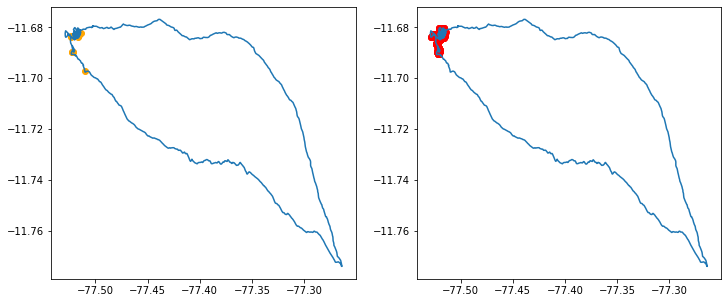

In [15]:
plt.figure(figsize= (12, 5))
plt.subplot(1, 2, 1)
plt.plot(np.array(t.lon), np.array(t.lat))
plt.scatter(t.lon[t.dive == 1], t.lat[t.dive == 1], c = 'orange')

plt.subplot(1, 2, 2)
plt.plot(np.array(t.lon), np.array(t.lat))
plt.scatter(t.lon[dive_plot == 1], t.lat[dive_plot == 1], c = 'red')

## score

In [16]:
# globally
all_real = 1* (np.hstack(dive_real)> 0)
all_estim = 1* (np.hstack(dive_estim) > 0)

true_positive = np.mean(all_estim[all_real == 1])
true_negative = 1-np.mean(all_estim[all_real == 0])

true_positive, true_negative

(0.80859375, 0.7845682350820263)

(0.9487179487179487, 0.6055900621118012)
(0.7368421052631579, 0.8190954773869347)
(0.5, 0.4158415841584159)
(0.9090909090909091, 0.4044943820224719)
(0.0, 0.9504132231404958)
(0.75, 0.7675675675675675)
(0.4, 0.9409368635437881)
(1.0, 0.7445255474452555)
(0.6842105263157895, 0.8680688336520077)
(1.0, 0.7991967871485943)
(0.9166666666666666, 0.5746268656716418)
(0.8, 0.676595744680851)
(0.7272727272727273, 0.819672131147541)
(0.9230769230769231, 0.7670250896057348)
(0.8461538461538461, 0.8096676737160121)
(0.8333333333333334, 0.7623642943305187)
(0.4, 0.9326923076923077)
(0.9523809523809523, 0.5627906976744186)
(0.5454545454545454, 0.8711433756805808)


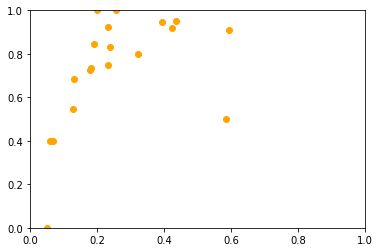

In [17]:
# for each trip
fig, ax = plt.subplots()
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

for i in range(len(dive_real)):
    
    real = 1*(dive_real[i]>0)
    estim = 1*(dive_estim[i]>0)
    
    true_positive = np.mean(estim[real == 1])
    true_negative = 1-np.mean(estim[real == 0])

    ax.scatter(1-true_negative, true_positive, c = 'orange')
    
    print((true_positive, true_negative))

# ROC curve

Change the decision threshold

In [18]:
# globally
TP = []
FP = []

all_real = 1* (np.hstack(dive_real)> 0)    
for tt in np.arange(-5, 5, 0.1):
    all_estim = 1* (np.hstack(dive_estim) > tt)
    true_positive = np.mean(all_estim[all_real == 1])
    true_negative = 1-np.mean(all_estim[all_real == 0])
    TP.append(true_positive)
    FP.append(1-true_negative)

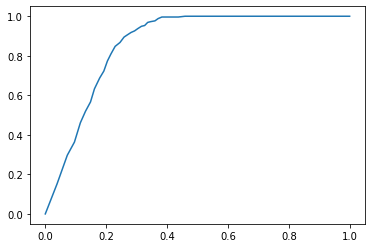

In [19]:
plt.plot(np.array(FP), np.array(TP))

In [21]:
data = {'model': 'simple_network_matrix',
        'FP':  FP,
        'TP': TP
        }

df = pd.DataFrame (data, columns = ['model','FP','TP'])

df.to_csv('./roc_simple_network_matrix.csv', index = False)